In [108]:
%load_ext autoreload
%autoreload 2

import json
from datetime import datetime
import os
from pathlib import Path
import re
import sys

import pandas as pd
import polars as pl
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm

ROOT_PATH = Path(os.path.abspath("")).parents[1]

sys.path.append(str(ROOT_PATH))
from src.functions.json_values import (
    get_json_values,
    get_json_values_parallel,
    select_value,
)
from src.functions.flatten_dict import flatten_dict

CLASSIFIED_PATH = ROOT_PATH / "data/classified"
SCRAPING_DAY = 22

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Extract date of classified
def get_day(file_name: str):
    ymd_groups = r"^classified_.+_(\d+)_(\d+).json$"
    year_string = re.findall(ymd_groups, file_name)[0][
        0
    ]  # First element of list, first group
    return datetime.strptime(year_string, "%Y%m%d").day

In [3]:
# Keep classified files that were captured on the 15th of May
list_filenames = os.listdir(CLASSIFIED_PATH)
new_list_filenames = []

for filename in list_filenames:
    try:
        filename_day = get_day(filename)
    except IndexError:
        print(
            filename
        )  # Some filenames are changed by mistakes <- shouldn't happen too often
        continue
    if filename_day == SCRAPING_DAY:
        new_list_filenames.append(filename)

list_filenames = new_list_filenames

classified_10000290apartmentforrent8600Diksmuide_20230522_212157.json~


In [4]:
# Read one file and extract useful variables
with open(CLASSIFIED_PATH / list_filenames[0]) as json_file:
    class_dict = json.load(json_file)

class_dict.keys()

dict_keys(['user', 'classified', 'customer', 'screen', 'other_defined', 'classified_table'])

In [5]:
# Find and select renting locations
list_transactions = get_json_values(
    list_filenames, CLASSIFIED_PATH, "classified", "transactionType"
)

In [6]:
# Get unique
np.unique(np.array(list_transactions))

array(['for rent', 'for sale'], dtype='<U8')

In [7]:
## Filter for rent and apartments
list_types = get_json_values(list_filenames, CLASSIFIED_PATH, "classified", "type")

In [8]:
np.array(np.unique(list_types))

array(['apartment', 'apartment group', 'house', 'house group'],
      dtype='<U15')

In [9]:
## Filter JSONS about apartment to rent
bl_type = np.isin(np.array(list_types), ["apartment", "apartment group"])
bl_transact = np.isin(np.array(list_transactions), "for rent")
bl = np.logical_and(bl_type, bl_transact)

list_apartrent = [filename for filename, b in zip(list_filenames, bl) if b]

In [10]:
# Possible values
pl.DataFrame(flatten_dict(select_value(list_apartrent[0], CLASSIFIED_PATH))).shape

(1, 75)

In [11]:
select_value(list_apartrent[0], CLASSIFIED_PATH)

{'user': {'loginStatus': 'logged out', 'id': '', 'personal': {'language': ''}},
 'classified': {'id': '10578471',
  'type': 'apartment',
  'subtype': 'apartment',
  'price': '1050',
  'transactionType': 'for rent',
  'zip': '1060',
  'visualisationOption': 'xl',
  'kitchen': {'type': 'installed'},
  'building': {'constructionYear': '1929', 'condition': 'good'},
  'energy': {'heatingType': 'gas'},
  'certificates': {'primaryEnergyConsumptionLevel': '324'},
  'bedroom': {'count': '2'},
  'land': {'surface': ''},
  'atticExists': '',
  'basementExists': '',
  'outdoor': {'garden': {'surface': ''}, 'terrace': {'exists': ''}},
  'specificities': {'SME': {'office': {'exists': 'true'}}},
  'wellnessEquipment': {'hasSwimmingPool': ''},
  'parking': {'parkingSpaceCount': {'indoor': '', 'outdoor': ''}},
  'condition': {'isNewlyBuilt': ''}},
 'customer': {'id': '2575488',
  'name': 'we invest bruxelles',
  'family': 'agency',
  'groupInfo': {'id': '', 'name': ''},
  'networkInfo': {'id': '', 'nam

In [12]:
# Defining component I want to extract from the apartments to rent
component_dict = {
    "listing_id": ["classified", "id"],
    "price": ["classified", "price"],
    "contact_type": ["customer", "family"],
    "contact_name": ["customer", "name"],
    "subtype": ["classified", "subtype"],
    "zip_code": ["classified", "zip"],
    "construction_year": ["building", "constructionYear"],
    "building_condition": ["building", "condition"],
    "energy_consumption": ["certificates", "primaryEnergyConsumptionLevel"],
    "energy_class": ["classified_table", "energy_class"],
    "n_bedrooms": ["bedroom", "count"],
    "land_surface": ["land", "surface"],
    "surroundings_type": ["classified_table", "surroundings_type"],
    "living_area": ["classified_table", "living_area"],
}

In [13]:
pl_apart = pl.DataFrame()

for key in component_dict.keys():
    data_arr = get_json_values(list_apartrent, CLASSIFIED_PATH, *component_dict[key])
    pl_apart = pl_apart.with_columns(pl.lit(data_arr).alias(key))


pl_apart.head()

listing_id,price,contact_type,contact_name,subtype,zip_code,construction_year,building_condition,energy_consumption,energy_class,n_bedrooms,land_surface,surroundings_type,living_area
str,str,str,str,str,str,f32,f32,f32,str,f32,f32,str,str
"""10578471""","""1050""","""agency""","""we invest brux…","""apartment""","""1060""",null,null,null,"""f""",null,null,"""urban""","""92"""
"""10579694""","""2750""","""agency""","""bathim &amp; c…","""penthouse""","""1050""",null,null,null,"""d""",null,null,"""urban""","""200"""
"""10578602""","""1250""","""agency""","""bathim &amp; c…","""apartment""","""1000""",null,null,null,"""b""",null,null,"""living area (r…","""50"""
"""10527337""","""1350""","""agency""","""place 4 you""","""duplex""","""1150""",null,null,null,"""g""",null,null,"""living area (r…","""80"""
"""10578603""","""1250""","""agency""","""bathim &amp; c…","""apartment""","""1030""",null,null,null,"""d""",null,null,"""isolated""","""85"""


In [14]:
# With price, save only max price, parse
price_list = pl_apart.select("price").to_numpy().ravel().tolist()

In [15]:
# Investigating strange price patterns
pattern = r"(\d+)(.*)"
for price in price_list:
    found = re.findall(pattern, price)
    try:
        if found[0][1] != "":
            print(found[0])
    except IndexError:
        print(found)

('900', ' - 922')
('950', ' - 1050')
('950', ' - 1390')
('915', ' - 915')
('860', ' - 1180')
[]
('825', ' - 995')
('765', ' - 853')
('950', ' - 1150')


In [16]:
adjusted_prices = []

pattern = r"(\d+)( - )?(\d+)"
for price in price_list:
    found = re.findall(pattern, price)
    try:
        if found[0][1] != "":
            adjusted_prices.append(found[0][2])
        else:
            adjusted_prices.append(price)
    except IndexError:
        adjusted_prices.append(None)

In [17]:
# Replace adjusted prices (we retain the max rent price)
pl_apart = pl_apart.with_columns(pl.lit(adjusted_prices).cast(pl.Int64).alias("price"))

In [18]:
# Cast rows as relevant
q = [
    pl.col("price").cast(pl.Int64),
    pl.col("n_bedrooms").cast(pl.Int64),
    pl.col("energy_consumption").cast(pl.Int64),
    pl.col("construction_year").cast(pl.Int64),
    pl.col("zip_code").cast(pl.Int64),
    pl.col("living_area").cast(pl.Float64),
]

pl_apart = pl_apart.with_columns(q)

In [19]:
pl_apart.head()

listing_id,price,contact_type,contact_name,subtype,zip_code,construction_year,building_condition,energy_consumption,energy_class,n_bedrooms,land_surface,surroundings_type,living_area
str,i64,str,str,str,i64,i64,f32,i64,str,i64,f32,str,f64
"""10578471""",1050,"""agency""","""we invest brux…","""apartment""",1060,null,null,null,"""f""",null,null,"""urban""",92.0
"""10579694""",2750,"""agency""","""bathim &amp; c…","""penthouse""",1050,null,null,null,"""d""",null,null,"""urban""",200.0
"""10578602""",1250,"""agency""","""bathim &amp; c…","""apartment""",1000,null,null,null,"""b""",null,null,"""living area (r…",50.0
"""10527337""",1350,"""agency""","""place 4 you""","""duplex""",1150,null,null,null,"""g""",null,null,"""living area (r…",80.0
"""10578603""",1250,"""agency""","""bathim &amp; c…","""apartment""",1030,null,null,null,"""d""",null,null,"""isolated""",85.0


In [20]:
# Contact types
pl_apart.groupby("contact_type").count()

contact_type,count
str,u32
"""private""",2434
"""property_devel…",163
"""notary""",1
"""company""",32
"""real_estate_ag…",121
"""agency_paying_…",127
"""agency""",7041
"""company_paying…",33


In [21]:
# Load zipcodes and coordinates data (and merge)
pl_zip = pl.read_csv(ROOT_PATH / "data/zipcode-belgium.csv", has_header=False)
pl_zip.columns = ["zip_code", "commune", "geo_long", "geo_lat"]

pl_zip.head()

zip_code,commune,geo_long,geo_lat
i64,str,f64,f64
1000,"""Bruxelles""",4.351697,50.846557
1020,"""Laeken""",4.3487134,50.883392
1030,"""Schaerbeek""",4.3737121,50.867604
1040,"""Etterbeek""",4.3895104,50.836851
1050,"""Ixelles""",4.3815707,50.822285


In [22]:
pl_apart = pl_apart.join(pl_zip, on="zip_code", how="left")

In [23]:
# Any coordinate data missing?
pl_apart.select(pl.col("geo_long").is_null().sum())

geo_long
u32
0


In [24]:
# Check for duplicate ids -> A lot
# Filter them out
q = pl.col("listing_id").is_duplicated().is_not()
pl_apart = pl_apart.filter(q)

In [25]:
# Read municipality shape file
gpd_municipalities = gpd.read_file(
    ROOT_PATH / "data/adminvector_3812.gpkg", layer="municipality"
)
gpd_municipalities.head()

,tgid,modifdate,arrondissementcapital,provincecapital,regioncapital,countrycapital,niscode,city,languagestatute,nameger,namefre,namedut,geometry
0,{8BF44CB0-B8FD-44F6-A64F-1307610DA4C9},2007-01-05,False,False,False,False,72004,1,1,Bree,Bree,Bree,"MULTIPOLYGON Z (((735277.942 700725.863 0.000,..."
1,{54A85359-4967-4318-AA63-D234DDED2FD7},2007-01-05,False,False,False,False,63004,0,2,Baelen,Baelen,Baelen,"MULTIPOLYGON Z (((767808.071 646176.387 0.000,..."
2,{95E2AAE2-F9DB-456C-A113-2A21ED6F932F},2007-01-05,False,False,False,False,13003,0,1,Balen,Balen,Balen,"MULTIPOLYGON Z (((708505.571 703629.811 0.000,..."
3,{4487B4B8-4422-4856-97C5-33174BF84028},2007-01-05,False,False,False,False,62011,0,2,Bassenge,Bassenge,Bitsingen,"MULTIPOLYGON Z (((738180.089 660714.898 0.000,..."
4,{68A224E9-B2E7-4225-9FDA-03AE2B9C8C41},2007-01-05,False,False,False,False,85046,0,2,Habay,Habay,Habay,"MULTIPOLYGON Z (((741033.075 543058.412 0.000,..."


In [26]:
# Convert to pandas
df_apart = pl_apart.to_pandas()

In [27]:
# Spatial join
apart_geom = [Point(x, y) for x, y in zip(df_apart["geo_long"], df_apart["geo_lat"])]
df_apart = df_apart.drop(["geo_long", "geo_lat"], axis=1)
gpd_apart = gpd.GeoDataFrame(df_apart, geometry=apart_geom)

In [28]:
gpd_municipalities = gpd_municipalities.to_crs("EPSG:4326")

In [29]:
gpd_apart = gpd_apart.sjoin(gpd_municipalities, how="left", predicate="within")

/home/marc/.conda/envs/immo_report/lib/python3.11/site-packages/geopandas/geodataframe.py:2178: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [30]:
gpd_apart.to_file(ROOT_PATH / "data/apart_geo.gpkg")

In [31]:
gpd_municipalities.to_file(ROOT_PATH / "data/municipalities_geo.gpkg")

In [32]:
gpd_municipalities.columns

Index(['tgid', 'modifdate', 'arrondissementcapital', 'provincecapital',
       'regioncapital', 'countrycapital', 'niscode', 'city', 'languagestatute',
       'nameger', 'namefre', 'namedut', 'geometry'],
      dtype='object')

In [33]:
gpd_municipalities.head()

,tgid,modifdate,arrondissementcapital,provincecapital,regioncapital,countrycapital,niscode,city,languagestatute,nameger,namefre,namedut,geometry
0,{8BF44CB0-B8FD-44F6-A64F-1307610DA4C9},2007-01-05,False,False,False,False,72004,1,1,Bree,Bree,Bree,"MULTIPOLYGON Z (((5.58659 51.11022 0.00000, 5...."
1,{54A85359-4967-4318-AA63-D234DDED2FD7},2007-01-05,False,False,False,False,63004,0,2,Baelen,Baelen,Baelen,"MULTIPOLYGON Z (((6.03343 50.61423 0.00000, 6...."
2,{95E2AAE2-F9DB-456C-A113-2A21ED6F932F},2007-01-05,False,False,False,False,13003,0,1,Balen,Balen,Balen,"MULTIPOLYGON Z (((5.20479 51.13968 0.00000, 5...."
3,{4487B4B8-4422-4856-97C5-33174BF84028},2007-01-05,False,False,False,False,62011,0,2,Bassenge,Bassenge,Bitsingen,"MULTIPOLYGON Z (((5.61834 50.75017 0.00000, 5...."
4,{68A224E9-B2E7-4225-9FDA-03AE2B9C8C41},2007-01-05,False,False,False,False,85046,0,2,Habay,Habay,Habay,"MULTIPOLYGON Z (((5.63023 49.69209 0.00000, 5...."


In [34]:
gpd_apart.head()

,listing_id,price,contact_type,contact_name,subtype,zip_code,construction_year,building_condition,energy_consumption,energy_class,...,arrondissementcapital,provincecapital,regioncapital,countrycapital,niscode,city,languagestatute,nameger,namefre,namedut
0,10578471,1050.0,agency,we invest bruxelles,apartment,1060,NaN,NaN,NaN,f,...,False,False,False,False,21013,0,4,Saint-Gilles,Saint-Gilles,Sint-Gillis
1,10579694,2750.0,agency,bathim &amp; co l’immobilier sur mesure,penthouse,1050,NaN,NaN,NaN,d,...,False,False,False,False,21009,0,4,Ixelles,Ixelles,Elsene
2,10578602,1250.0,agency,bathim &amp; co l’immobilier sur mesure,apartment,1000,NaN,NaN,NaN,b,...,True,False,True,True,21004,1,4,Brüssel,Bruxelles,Brussel
3,10527337,1350.0,agency,place 4 you,duplex,1150,NaN,NaN,NaN,g,...,False,False,False,False,21019,0,4,Woluwe-Saint-Pierre,Woluwe-Saint-Pierre,Sint-Pieters-Woluwe
4,10578603,1250.0,agency,bathim &amp; co l’immobilier sur mesure,apartment,1030,NaN,NaN,NaN,d,...,False,False,False,False,21015,0,4,Schaerbeek,Schaerbeek,Schaarbeek


In [35]:
# How many missing living area? -> Quite a bit
# Impute with number of rooms?
gpd_apart["living_area"].isna().sum()

776

In [36]:
# Get rent price per m2
gpd_apart["price_m2"] = np.round(gpd_apart["price"] / gpd_apart["living_area"], 2)

In [37]:
# I want the median and the deviation from the median (of a municipality)
gpd_apart["median_price_m2"] = gpd_apart.groupby("namedut")["price_m2"].transform(
    "median"
)
gpd_apart["deviation_price_m2"] = gpd_apart["price_m2"] - gpd_apart["median_price_m2"]

In [38]:
# Outliers?
gpd_apart.sort_values(["deviation_price_m2"], ascending=False).head()
# Remove listing 10370135, weird that it was approved -> more like a airbnb
gpd_apart = gpd_apart.loc[gpd_apart["listing_id"] != "10370135", :]

In [43]:
# Looking at more weirdstuff
fig = px.histogram(gpd_apart, x="deviation_price_m2")

fig.show()

In [44]:
gpd_apart.sort_values(["deviation_price_m2"], ascending=False).head()

,listing_id,price,contact_type,contact_name,subtype,zip_code,construction_year,building_condition,energy_consumption,energy_class,...,countrycapital,niscode,city,languagestatute,nameger,namefre,namedut,price_m2,median_price_m2,deviation_price_m2
2060,10511841,6900.0,private,,penthouse,1050,NaN,NaN,NaN,not specified,...,False,21009,0,4,Ixelles,Ixelles,Elsene,98.57,15.62,82.95
1737,10405438,3120.0,agency,antwerp sotheby&#039;s international realty,apartment,2000,NaN,NaN,NaN,a,...,False,11002,1,1,Antwerpen,Anvers,Antwerpen,52.00,11.94,40.06
1294,10424401,2750.0,private,,apartment,1000,NaN,NaN,NaN,not specified,...,True,21004,1,4,Brüssel,Bruxelles,Brussel,55.00,15.44,39.56
2494,10384511,3200.0,agency,antwerp sotheby&#039;s international realty,apartment,2018,NaN,NaN,NaN,not specified,...,False,11002,1,1,Antwerpen,Anvers,Antwerpen,49.23,11.94,37.29
2396,10384510,3200.0,agency,antwerp sotheby&#039;s international realty,apartment,2018,NaN,NaN,NaN,not specified,...,False,11002,1,1,Antwerpen,Anvers,Antwerpen,49.23,11.94,37.29


In [48]:
# Let's look at Leuven
gpd_apart.loc[gpd_apart["namedut"] == "Leuven", :].sort_values(
    "deviation_price_m2", ascending=False
).head(15)

,listing_id,price,contact_type,contact_name,subtype,zip_code,construction_year,building_condition,energy_consumption,energy_class,...,countrycapital,niscode,city,languagestatute,nameger,namefre,namedut,price_m2,median_price_m2,deviation_price_m2
4625,10554095,800.0,property_developer,syus housing,flat studio,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,50.00,14.175,35.825
4753,10091200,850.0,property_developer,syus housing,apartment,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,50.00,14.175,35.825
4752,10235156,850.0,property_developer,syus housing,kot,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,47.22,14.175,33.045
4725,10091199,850.0,property_developer,syus housing,apartment,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,47.22,14.175,33.045
3370,10470054,750.0,agency,bvm vastgoed,kot,3000,NaN,NaN,NaN,c,...,False,24062,1,1,Löwen,Louvain,Leuven,41.67,14.175,27.495
2549,10557704,735.0,agency,covas immo,flat studio,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,40.83,14.175,26.655
4605,10501453,640.0,property_developer,syus housing,kot,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,40.00,14.175,25.825
2675,10196033,980.0,agency,homiÉs,apartment,3000,NaN,NaN,NaN,b,...,False,24062,1,1,Löwen,Louvain,Leuven,39.20,14.175,25.025
4602,10501452,620.0,property_developer,syus housing,kot,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,38.75,14.175,24.575
4880,10469310,620.0,property_developer,syus housing,kot,3000,NaN,NaN,NaN,not specified,...,False,24062,1,1,Löwen,Louvain,Leuven,38.75,14.175,24.575


In [60]:
# Average deviation per contact name ->
# Include mode city and an example listing
# Ratio price m2
gpd_apart.groupby("contact_name").agg(
    {"deviation_price_m2": "mean", "contact_name": "count"}
).sort_values("deviation_price_m2", ascending=False).head(10)

,deviation_price_m2,contact_name
contact_name,,
trust real estate,32.257500,4
optimum,31.630000,3
antwerp sotheby&#039;s international realty,21.412368,19
century 21 woonkantoor,19.715000,1
studiôme,18.825000,3
syus housing,16.225256,41
century 21 sophimo wezemaal,14.852000,5
mexx international real estate,14.166000,5
belgoimmo sprl,13.603000,20


In [63]:
gpd_apart.groupby("contact_name").agg(
    {"deviation_price_m2": "mean", "contact_name": "count"}
).sort_values("deviation_price_m2", ascending=False).dropna().query(
    "contact_name > 1"
).tail(
    10
)

,deviation_price_m2,contact_name
contact_name,,
poplimont immobilier,-3.560000,2
antoine d.,-3.931667,3
candice kassowicz,-3.937500,2
immo wemmel,-3.940000,2
l&#039;objectif immobilier,-4.630000,6
macnash north,-4.775000,2
century 21 a à z immobilier,-4.936000,5
globalty,-4.937500,2
cap sud charleroi,-5.103333,3


In [84]:
# Mode city per contact name
gpd_contact = (
    gpd_apart.groupby(["contact_name", "namedut"])["namedut"]
    .count()
    .rename("count_city")
    .reset_index()
)

gpd_contact["max_count_city"] = gpd_contact.groupby("contact_name")[
    "count_city"
].transform("max")
gpd_contact = gpd_contact.loc[
    gpd_contact["count_city"] == gpd_contact["max_count_city"], :
].drop(["count_city", "max_count_city"], axis=1)
gpd_contact = gpd_contact.rename({"namedut": "contact_city_mode"}, axis=1)

gpd_apart = pd.merge(gpd_apart, gpd_contact, on="contact_name", how="left")

In [87]:
# Ratio deviation from median (also important to compare cities)
gpd_apart["ratio_deviation_price_m2"] = np.round(
    gpd_apart["price_m2"] / gpd_apart["median_price_m2"], 2
)

In [89]:
# The price per m2 probably depends on the living area (higher for smaller living area)

gpd_apart.groupby("contact_name").agg(
    {
        "deviation_price_m2": "mean",
        "contact_name": "count",
        "contact_city_mode": "first",
        "ratio_deviation_price_m2": "mean",
        "listing_id": "first",
    }
).sort_values("deviation_price_m2", ascending=False).head(10)

,deviation_price_m2,contact_name,contact_city_mode,ratio_deviation_price_m2,listing_id
contact_name,,,,,
trust real estate,32.257500,4,Ottignies-Louvain-la-Neuve,3.582500,10559599
optimum,31.630000,3,Antwerpen,3.650000,10521225
antwerp sotheby&#039;s international realty,21.412368,19,Antwerpen,2.793158,10254605
century 21 woonkantoor,19.715000,1,Gent,2.780000,10545692
studiôme,18.825000,3,Leuven,2.330000,10155768
syus housing,16.225256,41,Leuven,2.154615,10470584
century 21 sophimo wezemaal,14.852000,5,Leuven,2.032000,10450600
mexx international real estate,14.166000,5,Elsene,1.914000,10520258
belgoimmo sprl,13.603000,20,Elsene,1.875000,10571212


In [115]:
gpd_apart.groupby("contact_name").agg(
    {
        "deviation_price_m2": "mean",
        "contact_name": "count",
        "contact_city_mode": "first",
        "ratio_deviation_price_m2": "mean",
        "listing_id": "first",
    }
).query("contact_city_mode == 'Leuven'").sort_values(
    "deviation_price_m2", ascending=False
).head(
    10
)

,deviation_price_m2,contact_name,contact_city_mode,ratio_deviation_price_m2,listing_id
contact_name,,,,,
studiôme,18.825000,3,Leuven,2.330000,10155768
syus housing,16.225256,41,Leuven,2.154615,10470584
century 21 sophimo wezemaal,14.852000,5,Leuven,2.032000,10450600
covas immo,11.881667,4,Leuven,1.836667,10527300
homiÉs,9.546111,10,Leuven,1.674444,10484857
studentcomfort nv,5.768333,4,Leuven,1.406667,10477448
bvm vastgoed,5.364231,16,Leuven,1.377692,10483768
kwalis,5.285000,1,Leuven,1.370000,10252268
era vandendries,4.781667,3,Leuven,1.336667,10524461


In [105]:
# Find rows with both living area and price not missing
bl_valid = gpd_apart[["living_area", "price_m2"]].apply(
    lambda x: np.logical_not(np.any(np.isnan(x))), axis=1
)

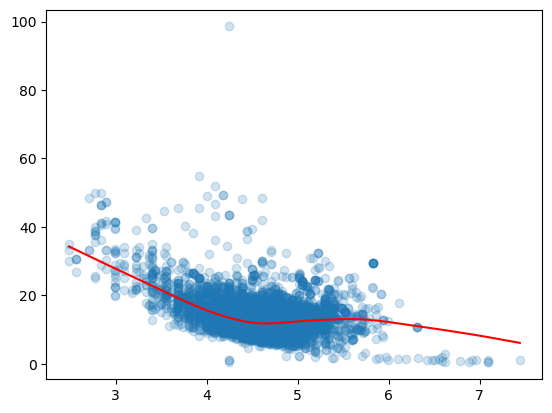

In [114]:
## Modeling m2 price per living area
loess_arr = sm.nonparametric.lowess(
    gpd_apart["price_m2"].loc[bl_valid], np.log(gpd_apart["living_area"].loc[bl_valid])
)

plt.plot(loess_arr[:, 0], loess_arr[:, 1], color="red")
plt.scatter(
    np.log(gpd_apart["living_area"].loc[bl_valid]),
    gpd_apart["price_m2"].loc[bl_valid],
    alpha=0.2,
)

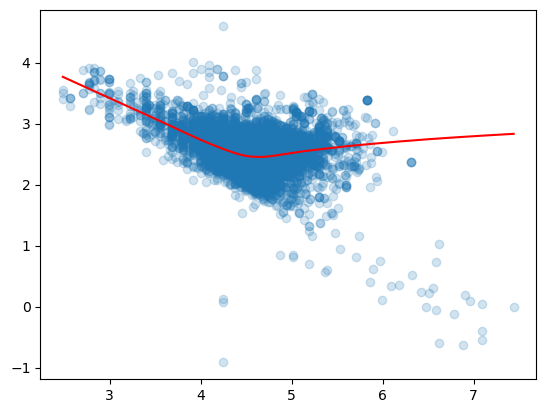

In [112]:
loess_arr = sm.nonparametric.lowess(
    np.log(gpd_apart["price_m2"].loc[bl_valid]),
    np.log(gpd_apart["living_area"].loc[bl_valid]),
)

plt.plot(loess_arr[:, 0], loess_arr[:, 1], color="red")
plt.scatter(
    np.log(gpd_apart["living_area"].loc[bl_valid]),
    np.log(gpd_apart["price_m2"].loc[bl_valid]),
    alpha=0.2,
)